# Renk Sabitliği ve Manipülasyon Dayanıklılığının Görüntü Sınıflandırma Performansına Etkisi
Sema Yalçın

In [1]:
import os
import shutil
import cv2
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Dropout

bu proje için veri setinden 10 sınıf seçildi.

In [2]:
source_dir = "Animals_with_Attributes2/JPEGImages"
target_dir = "Selected_Classes"

# Kullanılacak sınıflar
selected_classes = [
    "collie", "dolphin", "elephant", "fox", "moose", "rabbit", 
    "sheep", "squirrel", "giant+panda", "polar+bear"
]

image_size = (128, 128)

all_images = []
all_labels = []

Seçilen sınıfların her birinden 650 resim alınarak 'selected_classes' klsörüne koyalandı.

In [3]:
# Selected_Classes oluşturuldu.
if not os.path.exists(target_dir):
    os.makedirs(target_dir)

# Seçili sınıfları selected_classes klasörüne kopyalandı.
for class_name in selected_classes:
    source_class_dir = os.path.join(source_dir, class_name)
    target_class_dir = os.path.join(target_dir, class_name)

    if os.path.exists(source_class_dir):
        # Hedefteki sınıf klasörü oluşturuldu.
        os.makedirs(target_class_dir, exist_ok=True)

        # Dosyaları listelendi ve ilk 650 resim seçildi.
        images = sorted(os.listdir(source_class_dir))[:650]

        for image in images:
            source_image_path = os.path.join(source_class_dir, image)
            target_image_path = os.path.join(target_class_dir, image)

            # Dosya kopyalandı.
            shutil.copy(source_image_path, target_image_path)
            
            # Resmi yeniden boyutlandırdı ve normalize edildi.
            input_image = cv2.imread(source_image_path)
            if input_image is not None:
                img_resized = cv2.resize(input_image, image_size)
                img_normalized = img_resized / 255.0
                
                # Resim numpy dizisine çevrildi.
                all_images.append(img_normalized)
                all_labels.append(class_name)

                cv2.imwrite(target_image_path, (img_normalized * 255).astype('uint8'))

print("selected_classes oluşturuldu.")


selected_classes oluşturuldu.


In [4]:
# Veri numpy array'e çevrildi.
all_images = np.array(all_images)
all_labels = np.array(all_labels)

# Veri eğitim ve test olarak ayrıldı.
X_train, X_test, y_train, y_test = train_test_split(all_images, all_labels, test_size=0.3, random_state=42)

print(f"Eğitim verisi: {len(X_train)} resim, Test verisi: {len(X_test)} resim.")

Eğitim verisi: 4550 resim, Test verisi: 1950 resim.


veri artırma (augmentation) yöntemi olarak gürültü ekleme yapıldı.

Orijinal Eğitim Seti Boyutu: (4550, 128, 128, 3)
Yeni Eğitim Seti Boyutu (Gürültülü Veriler Dahil): (9100, 128, 128, 3)
Orijinal Etiket Sayısı: (4550,)
Yeni Etiket Sayısı (Gürültülü Veriler Dahil): (9100,)


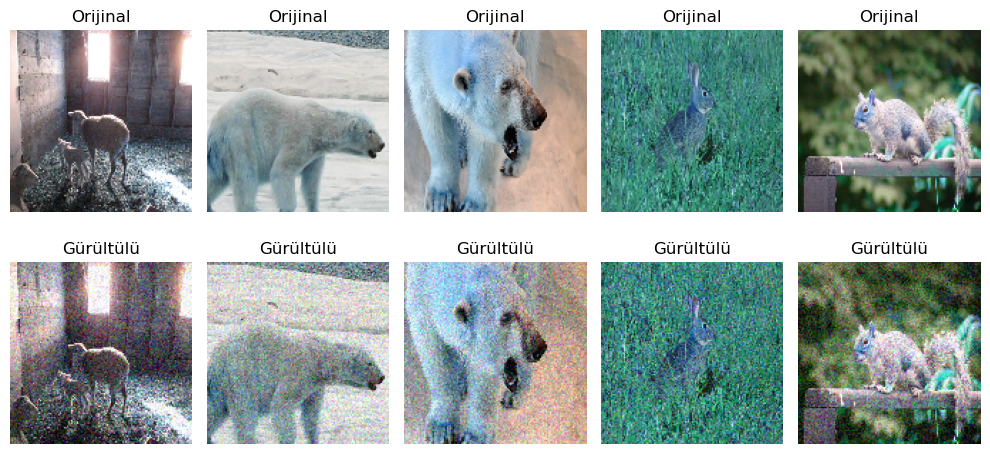

In [5]:
# Gürültü ekleme fonksiyonu
def add_gaussian_noise(image, mean=0, std=0.1):
    noise = np.random.normal(mean, std, image.shape)
    noisy_image = np.clip(image + noise, 0, 1)  # Değerleri [0, 1] arasında tut
    return noisy_image

# Gürültü eklenmiş veriler ve etiketler için boş listeler
augmented_images = []
augmented_labels = []

# Eğitim verilerine gürültü ekleme
for img, label in zip(X_train, y_train):
    noisy_img = add_gaussian_noise(img)
    
    # Gürültülü görüntüyü ekle
    augmented_images.append(noisy_img)
    augmented_labels.append(label)

# Orijinal eğitim verisini ve gürültülü veriyi birleştirme
X_train_augmented = np.concatenate((X_train, np.array(augmented_images)))
y_train_augmented = np.concatenate((y_train, np.array(augmented_labels)))

# Kontrol
print(f"Orijinal Eğitim Seti Boyutu: {X_train.shape}")
print(f"Yeni Eğitim Seti Boyutu (Gürültülü Veriler Dahil): {X_train_augmented.shape}")
print(f"Orijinal Etiket Sayısı: {y_train.shape}")
print(f"Yeni Etiket Sayısı (Gürültülü Veriler Dahil): {y_train_augmented.shape}")

# Görselleştirme
plt.figure(figsize=(10, 5))

# Orijinal ve Gürültü Eklenmiş Görüntü Karşılaştırması
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[i])
    plt.title("Orijinal")
    plt.axis("off")

    plt.subplot(2, 5, i + 6)
    plt.imshow(augmented_images[i])
    plt.title("Gürültülü")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [6]:
X_train = X_train_augmented
y_train = y_train_augmented

In [7]:
print(X_train.shape)
#y_train = y_train.reshape(-1, 1)
print(y_train.shape)

(9100, 128, 128, 3)
(9100,)


'fox, elephant' gibi string olan sınıf isimleri **Label encoding** ile tamsayıya çevrilmiştir. Sonrasında ise **one-hot encoding** uygulanmıştır.

In [10]:
# Label encoding (stringler tamsayıya çevrildi.)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# One-hot encoding
y_train_one_hot = to_categorical(y_train_encoded)
y_test_one_hot = to_categorical(y_test_encoded)

print("Label Encoded:", y_train_encoded)     
print("One-hot Encoded:\n", y_train_one_hot)

Label Encoded: [8 6 6 ... 4 4 1]
One-hot Encoded:
 [[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


In [11]:
print("One-hot Encoding Shape (y_train):", y_train_one_hot.shape) 
num_classes = len(label_encoder.classes_)
print("Sınıf Sayısı:", num_classes)

One-hot Encoding Shape (y_train): (9100, 10)
Sınıf Sayısı: 10


Bu Derin öğrenme modelinde Convolutional Neural Network (CNN) yapısı kullanılmıştır.
+ 3 katmanlı konvolüsyonel ağ, MaxPooling katmanları ile tasarlanmıştır.
+ Overfitting azaltmak için Dropout katmanı eklenmiştir.
+ Son katmanda, sınıflandırma için Softmax aktivasyonu kullanılmıştır.

In [8]:
# modelim

model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))  # %25 dropout
model.add(Conv2D(64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))  # %50 dropout
model.add(Conv2D(128, kernel_size=(5, 5), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))  # %50 dropout
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # %50 dropout
model.add(Dense(10, activation='softmax'))

model.build()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 62, 62, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 58, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 29, 29, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 29, 29, 64)        0

In [9]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
# model eğitildi.

history = model.fit(
    X_train, y_train_one_hot,
    validation_data=(X_test, y_test_one_hot),
    epochs=10,
    batch_size=32,
    verbose=1
)

Epoch 1/10
285/285 [==============================] - 163s 564ms/step - loss: 2.0661 - accuracy: 0.2297 - val_loss: 1.9209 - val_accuracy: 0.3082
Epoch 2/10
285/285 [==============================] - 153s 537ms/step - loss: 1.7882 - accuracy: 0.3664 - val_loss: 1.6033 - val_accuracy: 0.4523
Epoch 3/10
285/285 [==============================] - 153s 538ms/step - loss: 1.5677 - accuracy: 0.4571 - val_loss: 1.3988 - val_accuracy: 0.5236
Epoch 4/10
285/285 [==============================] - 153s 537ms/step - loss: 1.3881 - accuracy: 0.5146 - val_loss: 1.2539 - val_accuracy: 0.5728
Epoch 5/10
285/285 [==============================] - 152s 534ms/step - loss: 1.2273 - accuracy: 0.5730 - val_loss: 1.2260 - val_accuracy: 0.6041
Epoch 6/10
285/285 [==============================] - 154s 542ms/step - loss: 1.1021 - accuracy: 0.6186 - val_loss: 1.1774 - val_accuracy: 0.5990
Epoch 7/10
285/285 [==============================] - 152s 533ms/step - loss: 0.9797 - accuracy: 0.6599 - val_loss: 1.1628 -

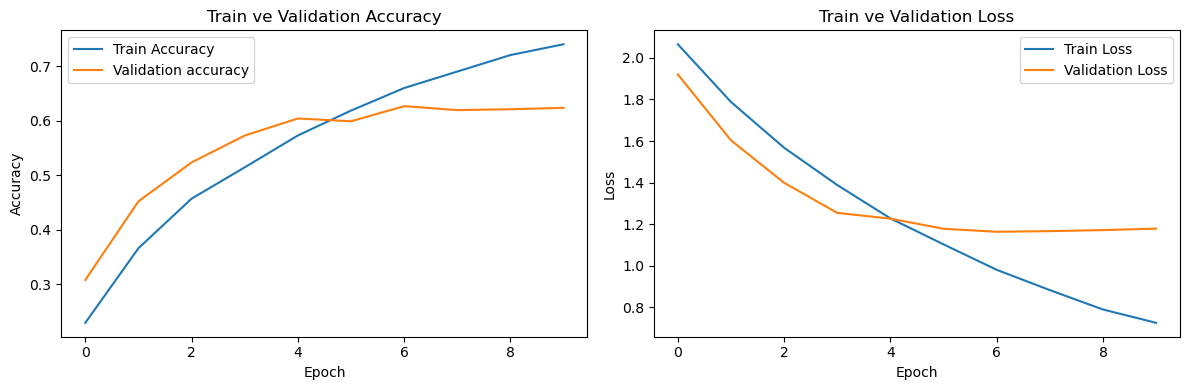

In [13]:
# Eğitim(Train) ve doğrulama(Validation) grafikleri

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Doğruluk grafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train ve Validation Accuracy')

# Loss grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train ve Validation Loss')

plt.tight_layout()
plt.show()


In [14]:
# Test verisi ile modeli değerlendirme
test_loss, test_accuracy = model.evaluate(X_test, y_test_one_hot, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

61/61 [==============================] - 9s 143ms/step - loss: 1.1780 - accuracy: 0.6236
Test Loss: 1.1779844760894775
Test Accuracy: 62.36%


Aşağıdaki kodlar resimlerin **farklı ışıklar altında maipüle edilmesi** ve **renk sabitliği** uygulanması için gereken fonksiyonlardır.

In [15]:
# Functions

def linearize_image(image):
    """
    Converts an sRGB image to linear RGB assuming the input image is in the range [0, 1]
    """
    return np.where(image <= 0.04045,
                    image / 12.92,
                    ((image + 0.055) / 1.055) ** 2.4)

def linear_to_srgb(image):
    """
    Converts a linear RGB image to sRGB assuming the input image is in the range [0, 1]
    """
    return np.where(image <= 0.0031308,
                    image * 12.92,
                    1.055 * (image ** (1 / 2.4)) - 0.055)


def manipulate_light_source(image, light_color):
    """
    Simulates color manipulation under a different light source

    Args:
    - image: The input image (sRGB, [0, 1])
    - light_color: The light source color (unit norm RGB vector)

    Returns:
    - Manipulated image (sRGB, [0, 1])
    """
    # Step 1: Linearize the image
    linear_image = linearize_image(image)

    # Step 2: Apply the light source (multiplying the linear image by the light color)
    manipulated_image = linear_image * light_color

    # Step 3: Convert the manipulated image back to sRGB
    manipulated_srgb = linear_to_srgb(manipulated_image)

    return np.clip(manipulated_srgb, 0, 1)

# Light sources for color manipulation
def get_light_sources():
    """
    Returns a set of light sources for image manipulation
    """
    purplish_light = np.array([0.82, 0.15, 0.89]) / np.linalg.norm([0.82, 0.15, 0.89])
    yellowish_light = np.array([0.96, 0.24, 0.11]) / np.linalg.norm([0.96, 0.24, 0.11])
    greenish_light = np.array([0.11, 0.98, 0.12]) / np.linalg.norm([0.11, 0.98, 0.12])
    return purplish_light, yellowish_light, greenish_light

def get_manipulated_images(image):
    """
    Get manipulated images by applying color vectors
    """
    
    # Get the color vectors
    purplish_light, orangish_light, greenish_light = get_light_sources()

    # Manipulate the images under different light sources
    manipulated_purplish = manipulate_light_source(image, purplish_light)
    manipulated_orangish = manipulate_light_source(image, orangish_light)
    manipulated_greenish = manipulate_light_source(image, greenish_light)

    
    return manipulated_purplish, manipulated_orangish, manipulated_greenish


def handle_saturation(image, lower=0.05, upper=0.95):
    """
    Creates a mask for non-saturated pixels (those between `lower` and `upper` thresholds)
    """
    return np.all((image > lower) & (image < upper), axis=-1)


def estimate_light_source_grey_world(image, mask):
    """
    Estimates the light source based on the Grey World assumption, using valid pixels from the mask
    """ 
    valid_pixels = image[mask]
    avg_color = np.mean(valid_pixels, axis=0)
    return avg_color / np.linalg.norm(avg_color)


def correct_colors(image, light_source):
    """
    Corrects the colors of the image by applying white balance using the estimated light source
    """
    return image * (1.0 / light_source)


def process_and_white_balance(image):
    """
    Applies white balance using both the Grey World and Max RGB methods
    Returns both corrected images in sRGB format
    """
    linear_image = linearize_image(image)
    valid_mask = handle_saturation(linear_image)

    # Light source estimations
    grey_world_light = estimate_light_source_grey_world(linear_image, valid_mask)

    # Color correction using both light sources
    corrected_grey_world = correct_colors(linear_image, grey_world_light)

    # Convert back to sRGB
    srgb_grey_world = linear_to_srgb(corrected_grey_world)

    # Clip and return
    return np.clip(srgb_grey_world, 0, 1)


def get_wb_images(image):
    """
    Process and white balance the image
    """
    
    srgb_grey_world = process_and_white_balance(image)

    return srgb_grey_world

In [16]:
# Test verilerini manipüle etme ve manipüle edilmiş verileri saklama

manipulated_images = []
manipulated_labels = []

# Test setindeki her görüntü için manipülasyon uygulama
for img, label in zip(X_test, y_test):
    
    manipulated_purplish, manipulated_orangish, manipulated_greenish = get_manipulated_images(img)
    
    # Manipüle edilmiş görüntüleri ve etiketlerini listeye ekle
    manipulated_images.extend([manipulated_purplish, manipulated_orangish, manipulated_greenish])
    manipulated_labels.extend([label, label, label]) 

Orijinal Test Seti Boyutu: (1950, 128, 128, 3)
Manipüle Edilmiş Test Seti Boyutu: (5850, 128, 128, 3)
Manipüle Edilmiş Etiket Sayısı: (5850,)


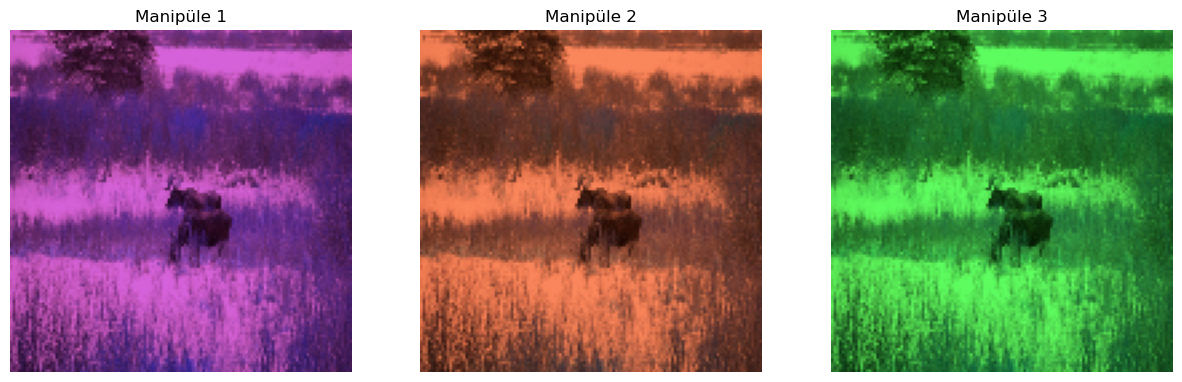

In [17]:
# Manipüle edilmiş test setini numpy array'e çevir
X_test_manipulated = np.array(manipulated_images)
y_test_manipulated = np.array(manipulated_labels)

# Test etiketlerini encode et
y_test_manipulated_encoded = label_encoder.transform(y_test_manipulated)
y_test_manipulated_one_hot = to_categorical(y_test_manipulated_encoded)

# Kontrol için boyut bilgilerini yazdırma
print(f"Orijinal Test Seti Boyutu: {X_test.shape}")
print(f"Manipüle Edilmiş Test Seti Boyutu: {X_test_manipulated.shape}")
print(f"Manipüle Edilmiş Etiket Sayısı: {y_test_manipulated.shape}")

# Manipüle edilmiş bir görüntüyü görselleştirme
plt.figure(figsize=(15, 5))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(X_test_manipulated[i])
    plt.title(f"Manipüle {i+1}")
    plt.axis("off")
plt.show()

In [18]:
# Test verisi ile modeli değerlendirme

test_loss, test_accuracy = model.evaluate(X_test_manipulated, y_test_manipulated_one_hot, verbose=1)

print(f"Manipüle Edilmiş Test Seti için Test Loss: {test_loss}")
print(f"Manipüle Edilmiş Test Seti için Test Accuracy: {test_accuracy * 100:.2f}%")

183/183 [==============================] - 22s 116ms/step - loss: 3.7433 - accuracy: 0.2051
Manipüle Edilmiş Test Seti için Test Loss: 3.7433173656463623
Manipüle Edilmiş Test Seti için Test Accuracy: 20.51%


In [19]:
# Renk sabitliği uygulanmış test setini oluşturma

X_test_wb = np.array([get_wb_images(image) for image in X_test_manipulated])
y_test_wb = y_test_manipulated_one_hot 

print(f"X_test_wb şekli: {X_test_wb.shape}, y_test_wb şekli: {y_test_wb.shape}")

C:\Users\User\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\User\anaconda3\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


X_test_wb şekli: (5850, 128, 128, 3), y_test_wb şekli: (5850, 10)


In [22]:
# Modeli renk sabitliği uygulanmış veriyle değerlendirme
test_loss, test_accuracy = model.evaluate(X_test_wb, y_test_wb, verbose=1)

print(f"Renk Sabitliği Uygulanmış Test Seti için Test Loss: {test_loss}")
print(f"Renk Sabitliği Uygulanmış Test Seti için Test Accuracy: {test_accuracy * 100:.2f}%")

183/183 [==============================] - 24s 130ms/step - loss: 1.2704 - accuracy: 0.5968
Renk Sabitliği Uygulanmış Test Seti için Test Loss: 1.27035391330719
Renk Sabitliği Uygulanmış Test Seti için Test Accuracy: 59.68%
